In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
from ipywidgets import interact 
import seaborn as sns
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import tensorflow as tf
import numpy as np

In [2]:
torch.__version__

'2.1.0'

# Loading Data

In [3]:
dataset = load_dataset("trec")
train_dataset = dataset['train']
test_dataset = dataset['test']

In [4]:
train_df = pd.DataFrame({'text' : train_dataset['text'], 'coarse_label' : train_dataset['coarse_label']})
test_df = pd.DataFrame({'text' : test_dataset['text'], 'coarse_label' : test_dataset['coarse_label']})

In [5]:
train_df.head()

,text,coarse_label
0,How did serfdom develop in and then leave Russ...,2
1,What films featured the character Popeye Doyle ?,1
2,How can I find a list of celebrities ' real na...,2
3,What fowl grabs the spotlight after the Chines...,1
4,What is the full form of .com ?,0


In [6]:
from sklearn.model_selection import train_test_split
initial_labeled_set, pool = train_test_split(train_df, test_size=0.95, stratify=train_df['coarse_label'])

# Spliting Data into train_encodings, test_encodings

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [8]:
train_encodings = tokenizer(initial_labeled_set['text'].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test_df['text'].to_list(), truncation=True, padding=True)
train_labels = initial_labeled_set.coarse_label.to_list()
test_labels = test_df.coarse_label.to_list()

In [9]:
num_labels = 6
id_to_label = {0 : 'ABBR' , 1 : 'ENTY', 2: 'DESC', 3 : 'HUM', 4 : 'LOC', 5 : 'NUM'}
label_to_id= { 'ABBR' : 0 , 'ENTY' : 1, 'DESC': 2, 'HUM' :3, 'LOC' : 4, 'NUM' : 5}

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6, id2label = id_to_label, label2id = label_to_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### TrainingArguments, Dataloader, Metrics are needed to construct this Fine-tune the model

In [11]:
training_args = TrainingArguments(
    output_dir='./BERTModel2',
    do_train=True,
    do_eval=True,
    num_train_epochs=5,  # Adjust the number of epochs as needed for each subset.
    per_device_train_batch_size=10,  # Adjust batch size for your hardware and data.
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
)


In [12]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)

In [13]:
def compute_metrics(pred):
    
    ''' 
    Compute Metrics

    This function computes various classification metrics based on the model's predictions and true labels, 
    including accuracy, F1 score, precision, and recall.

    Args:
        pred: A prediction object containing the true labels and predicted probabilities.

    Returns:
        metrics (dict): A dictionary containing the computed metrics:
            - 'Accuracy': The accuracy of the model's predictions.
            - 'F1': The macro F1 score.
            - 'Precision': The macro precision score.
            - 'Recall': The macro recall score.'''


    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

# Calling our Dataloader

In [14]:
train_dataloader = DataLoader(train_encodings,train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [15]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

#  Evaluate the prediction accuracy of our model on the dataset without training or fine-tuning it

In [16]:
predictions = trainer.predict(test_dataloader)


  0%|          | 0/16 [00:00<?, ?it/s]

In [17]:
predicted_labels = predictions.predictions.argmax(axis=1)


In [18]:
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))

accuracy 13.0% 


## An Active Learning Approach Based On Uncertain Sampling

In [19]:
initial_labeled_set.head() # so we fine_tune with the inital_labeled data

,text,coarse_label
2535,What Russian novel embracing more the 5 charac...,1
587,How many dots make up the symbol for `` becaus...,5
4831,What is state tree of Nebraska ?,1
5090,What nation boarders Mozambique ?,4
4330,Who won two gold medals in skiing in the Olymp...,3


In [20]:
initial_labeled_set.shape

(272, 2)

# 

In [21]:
def entropy_for_each_row(class_probabilities):
    """ Calculate entropy for each row in the array """
    return -tf.reduce_sum(class_probabilities * tf.math.log(class_probabilities),axis=1)

In [22]:
def predict_and_calculate_entropy(data):
    
    ''' 
    Predict and Calculate Entropy
    
    This function makes predictions using a pre-trained BERT model, calculates the entropy (uncertainty) of these predictions, 
    and creates a DataFrame containing relevant information.
    
    Args:
        data (DataFrame): A Pandas DataFrame containing text data and associated labels. The DataFrame should have 
        columns 'text' for text data and 'coarse_label' for labels.

    Returns:
        final_df (DataFrame): A Pandas DataFrame containing the following columns:
            - 'text': The original text data.
            - 'predicted_Label': The predicted class labels based on the model's predictions.
            - 'predicted_Probability': The maximum predicted probability for each instance.
            - 'Entropy': The calculated entropy (uncertainty) for each instance.
            - 'coarse_label': The original coarse labels from the input data. ''' 

    
            
    # Sample the Data 
    data_encodings = tokenizer(data['text'].to_list(), truncation=True, padding=True)
    dataloader = DataLoader(data_encodings, data.coarse_label.to_list())

    # Make predictions with class_probabilities and calculate entropy (uncertainty) 
    predictions = trainer.predict(dataloader)
    prediction_probabilities = tf.constant(predictions.predictions)

    # Predicted Labels 
    predicted_labels = predictions.predictions.argmax(axis=1)

    
    # Prediction probabilities, returning the highest probability for each instance
    prediction_probabilities_max = np.amax(prediction_probabilities, axis=1)

    # Calculate entropy for each instance
    entropies = entropy_for_each_row(tf.nn.softmax(prediction_probabilities))

    entropy_df = pd.DataFrame(
        {'text' : data['text'].to_list(),
         'predicted_Label': predicted_labels,
         'predicted_Probability': prediction_probabilities_max,
         'Entropy': entropies},
        index=data.index
    )

    final_df = pd.concat([data['coarse_label'], entropy_df], axis=1)

    return final_df.sort_values(by=['Entropy'],ascending=False)


In [23]:
test_df['coarse_label'].skew()

0.09677453168815325

# Simulated Active Learning

In [24]:
initial_labeled_set = test_df.head(150)

In [25]:
initial_labeled_set

,text,coarse_label
0,How far is it from Denver to Aspen ?,5
1,"What county is Modesto , California in ?",4
2,Who was Galileo ?,3
3,What is an atom ?,2
4,When did Hawaii become a state ?,5
...,...,...
145,What is the longest bone in the human body ?,1
146,Who is a German philosopher ?,3
147,What were Christopher Columbus ' three ships ?,1
148,What does Phi Beta Kappa mean ?,2


In [26]:
hundreds_rows_pred = predict_and_calculate_entropy(initial_labeled_set)

  0%|          | 0/5 [00:00<?, ?it/s]

In [27]:
hundreds_rows_pred

,coarse_label,text,predicted_Label,predicted_Probability,Entropy
145,1,What is the longest bone in the human body ?,3,0.105617,1.770714
78,5,How much does the human adult female brain wei...,3,0.110234,1.770027
130,5,How far is a nautical mile ?,3,0.120144,1.768600
48,5,How many liters in a gallon ?,3,0.254239,1.756301
10,4,What city had a world fair in 1900 ?,3,0.321231,1.753215
...,...,...,...,...,...
76,1,What type of currency is used in Australia ?,3,0.892213,1.595101
116,5,When did the Hindenberg crash ?,3,0.897621,1.584383
34,5,When did John F. Kennedy get elected as Presid...,3,0.942374,1.574686
82,3,Who was elected president of South Africa in 1...,3,0.939950,1.570137


In [28]:
#initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:70]['text'].to_list(), truncation=True, padding=True)
#initial_labeled_labels = hundreds_rows_pred[0:70].coarse_label.to_list()
#initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

In [29]:
'''trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )'''

'trainer = Trainer(\n        #the pre-trained bert model that will be fine-tuned\n        model=model,\n        #training arguments that we defined above\n        args=training_args,\n        train_dataset= initial_labeled_dataloader,\n        eval_dataset = test_dataloader,\n        compute_metrics= compute_metrics\n    )'

In [30]:
'''trainer.train()
metrics = trainer.evaluate()'''

'trainer.train()\nmetrics = trainer.evaluate()'

In [31]:
#metrics

# Active Learning

In [32]:
# Initialize empty lists to store metrics for each iteration
accuracy_list = []
precision_list = []
recall_list = []
loss_list = []
x_labels = []
n = 0

for iteration in range(15):
    n += 10
    print(n)
    initial_labeled_encoding = tokenizer(hundreds_rows_pred[0:n]['text'].to_list(), truncation=True, padding=True)
    initial_labeled_labels = hundreds_rows_pred[0:n].coarse_label.to_list()
    initial_labeled_dataloader = DataLoader(initial_labeled_encoding,initial_labeled_labels)

   
    trainer = Trainer(
        #the pre-trained bert model that will be fine-tuned
        model=model,
        #training arguments that we defined above
        args=training_args,
        train_dataset= initial_labeled_dataloader,
        eval_dataset = test_dataloader,
        compute_metrics= compute_metrics
    )

    trainer.train()

    metrics = trainer.evaluate()

    print('eval_Accuracy :',metrics['eval_Accuracy'])

    accuracy_list.append(metrics['eval_Accuracy'])
    precision_list.append(metrics['eval_Precision'])
    recall_list.append(metrics['eval_Recall'])
    loss_list.append(metrics['eval_loss'])
    x_labels.append(n)



10


  0%|          | 0/5 [00:00<?, ?it/s]

{'train_runtime': 0.5618, 'train_samples_per_second': 88.994, 'train_steps_per_second': 8.899, 'train_loss': 1.8423221588134766, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.13
20


  0%|          | 0/10 [00:00<?, ?it/s]

{'train_runtime': 1.0065, 'train_samples_per_second': 99.351, 'train_steps_per_second': 9.935, 'train_loss': 1.759231185913086, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.142
30


  0%|          | 0/15 [00:00<?, ?it/s]

{'train_runtime': 1.4818, 'train_samples_per_second': 101.231, 'train_steps_per_second': 10.123, 'train_loss': 1.666421635945638, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.134
40


  0%|          | 0/20 [00:00<?, ?it/s]

{'train_runtime': 1.9234, 'train_samples_per_second': 103.984, 'train_steps_per_second': 10.398, 'train_loss': 1.5885765075683593, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.218
50


  0%|          | 0/25 [00:00<?, ?it/s]

{'train_runtime': 2.381, 'train_samples_per_second': 104.997, 'train_steps_per_second': 10.5, 'train_loss': 1.4505204772949218, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.364
60


  0%|          | 0/30 [00:00<?, ?it/s]

{'train_runtime': 2.8441, 'train_samples_per_second': 105.482, 'train_steps_per_second': 10.548, 'train_loss': 1.2436739603678386, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.426
70


  0%|          | 0/35 [00:00<?, ?it/s]

{'train_runtime': 3.3356, 'train_samples_per_second': 104.928, 'train_steps_per_second': 10.493, 'train_loss': 1.007739475795201, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.658
80


  0%|          | 0/40 [00:00<?, ?it/s]

{'train_runtime': 3.9041, 'train_samples_per_second': 102.455, 'train_steps_per_second': 10.246, 'train_loss': 0.7490172863006592, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.86
90


  0%|          | 0/45 [00:00<?, ?it/s]

{'train_runtime': 4.4089, 'train_samples_per_second': 102.066, 'train_steps_per_second': 10.207, 'train_loss': 0.4471263461642795, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.868
100


  0%|          | 0/50 [00:00<?, ?it/s]

{'loss': 0.2382, 'learning_rate': 2.5e-05, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.4574562609195709, 'eval_Accuracy': 0.874, 'eval_F1': 0.7273189489425249, 'eval_Precision': 0.8946425791358426, 'eval_Recall': 0.7378901712183653, 'eval_runtime': 0.7145, 'eval_samples_per_second': 699.821, 'eval_steps_per_second': 22.394, 'epoch': 5.0}
{'train_runtime': 5.5663, 'train_samples_per_second': 89.825, 'train_steps_per_second': 8.983, 'train_loss': 0.23815710067749024, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.874
110


  0%|          | 0/55 [00:00<?, ?it/s]

{'loss': 0.0877, 'learning_rate': 2.5e-05, 'epoch': 4.55}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.38206735253334045, 'eval_Accuracy': 0.894, 'eval_F1': 0.7449266256291808, 'eval_Precision': 0.9117108500327676, 'eval_Recall': 0.7531526885725673, 'eval_runtime': 0.7007, 'eval_samples_per_second': 713.62, 'eval_steps_per_second': 22.836, 'epoch': 4.55}
{'train_runtime': 5.9881, 'train_samples_per_second': 91.848, 'train_steps_per_second': 9.185, 'train_loss': 0.08238541077483784, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.912
120


  0%|          | 0/60 [00:00<?, ?it/s]

{'loss': 0.0192, 'learning_rate': 2.5e-05, 'epoch': 4.17}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.3932999074459076, 'eval_Accuracy': 0.91, 'eval_F1': 0.760922263238491, 'eval_Precision': 0.9260850110796036, 'eval_Recall': 0.7671151598636438, 'eval_runtime': 0.7064, 'eval_samples_per_second': 707.851, 'eval_steps_per_second': 22.651, 'epoch': 4.17}
{'train_runtime': 6.5399, 'train_samples_per_second': 91.745, 'train_steps_per_second': 9.175, 'train_loss': 0.017326958725849786, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.906
130


  0%|          | 0/65 [00:00<?, ?it/s]

{'loss': 0.0107, 'learning_rate': 2.5e-05, 'epoch': 3.85}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.41174033284187317, 'eval_Accuracy': 0.912, 'eval_F1': 0.7640213675514173, 'eval_Precision': 0.9285834625543306, 'eval_Recall': 0.7689017693774024, 'eval_runtime': 0.6993, 'eval_samples_per_second': 714.967, 'eval_steps_per_second': 22.879, 'epoch': 3.85}
{'train_runtime': 7.0793, 'train_samples_per_second': 91.817, 'train_steps_per_second': 9.182, 'train_loss': 0.008772633167413564, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.912
140


  0%|          | 0/70 [00:00<?, ?it/s]

{'loss': 0.022, 'learning_rate': 2.5e-05, 'epoch': 3.57}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.45141831040382385, 'eval_Accuracy': 0.918, 'eval_F1': 0.7693698161063484, 'eval_Precision': 0.9337410342790035, 'eval_Recall': 0.7741582806622825, 'eval_runtime': 0.726, 'eval_samples_per_second': 688.71, 'eval_steps_per_second': 22.039, 'epoch': 3.57}
{'train_runtime': 8.0731, 'train_samples_per_second': 86.708, 'train_steps_per_second': 8.671, 'train_loss': 0.016041334186281477, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.914
150


  0%|          | 0/75 [00:00<?, ?it/s]

{'loss': 0.0006, 'learning_rate': 2.5e-05, 'epoch': 3.33}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.5572397708892822, 'eval_Accuracy': 0.918, 'eval_F1': 0.7695751718559545, 'eval_Precision': 0.9335177509284573, 'eval_Recall': 0.7742209183135725, 'eval_runtime': 0.7169, 'eval_samples_per_second': 697.479, 'eval_steps_per_second': 22.319, 'epoch': 3.33}
{'train_runtime': 8.6162, 'train_samples_per_second': 87.045, 'train_steps_per_second': 8.705, 'train_loss': 0.00046497592081626255, 'epoch': 5.0}


  0%|          | 0/16 [00:00<?, ?it/s]

eval_Accuracy : 0.914


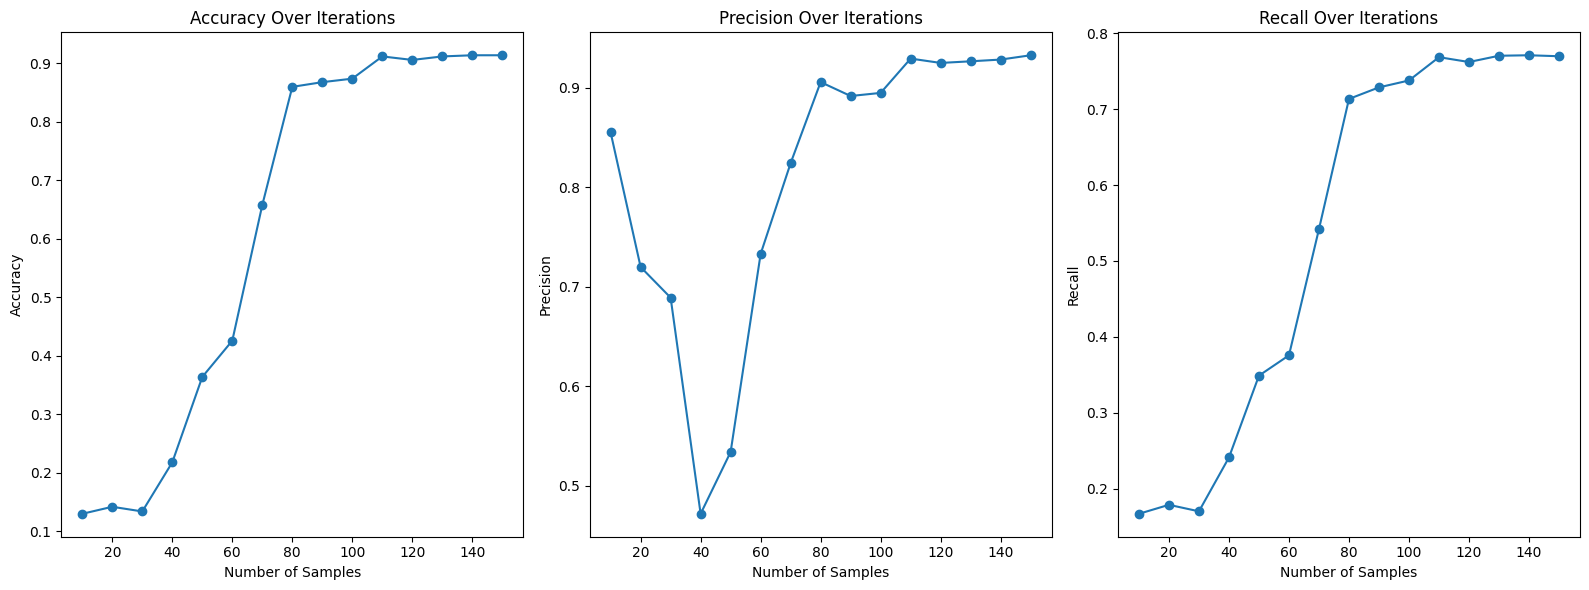

In [33]:
# Plot the metrics
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(x_labels, accuracy_list, marker='o')
plt.title('Accuracy Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(x_labels, precision_list, marker='o')
plt.title('Precision Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Precision')

plt.subplot(1, 3, 3)
plt.plot(x_labels, recall_list, marker='o')
plt.title('Recall Over Iterations')
plt.xlabel('Number of Samples')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

In [34]:
predictions = trainer.predict(test_dataloader)
predicted_labels = predictions.predictions.argmax(axis=1)
accuracy = accuracy_score(test_df['coarse_label'].to_list(),predicted_labels)
print('accuracy {}% '.format(np.round(accuracy * 100)))


  0%|          | 0/16 [00:00<?, ?it/s]

accuracy 91.0% 


# Confusion Matrix